<a href="https://colab.research.google.com/github/aarandjel/importance-sampling-with-feedforward-networks/blob/main/arithmetic_asian_basket_call_multivariate_Black_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importance sampling for option pricing with feedforward networks

In this Jupyter notebook, we study the problem of reducing the standard error in Monte Carlo simulations when pricing path-dependent options through suitable changes of measure which are induced by feedforward networks.

We consider an arithmetic Asian basket call option in a multivariate Black-Scholes model.

In [1]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import norm
from tqdm.notebook import trange
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Concatenate, Subtract, Multiply, Lambda, Add, Dot
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

Python version:  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Tensorflow version:  2.6.0
Keras version:  2.6.0


In [2]:
T = 1
N = 32
delta_t = T/N
strike = 70.0
r = 0.05
N_assets = 10
N_train = 2*10**5
learnrate = 0.01

In [9]:
X_0 = np.around(np.random.uniform(low=40.0, high=50.0, size=(N_assets,1)),0)
mu = np.around(np.random.uniform(low=0.0, high=0.10, size=(N_assets, 1)),2)
sigma = np.around(np.random.uniform(low=-0.3, high=0.3, size=(N_assets,N_assets)), 2)
volvec = (norm(sigma, axis=0) ** 2).reshape((N_assets,1))
tilde_mu = mu - 0.5 * volvec

weights = np.around(mu / (norm(sigma, axis=0)).reshape((N_assets,1)),2)
weights = weights / np.sum(weights)

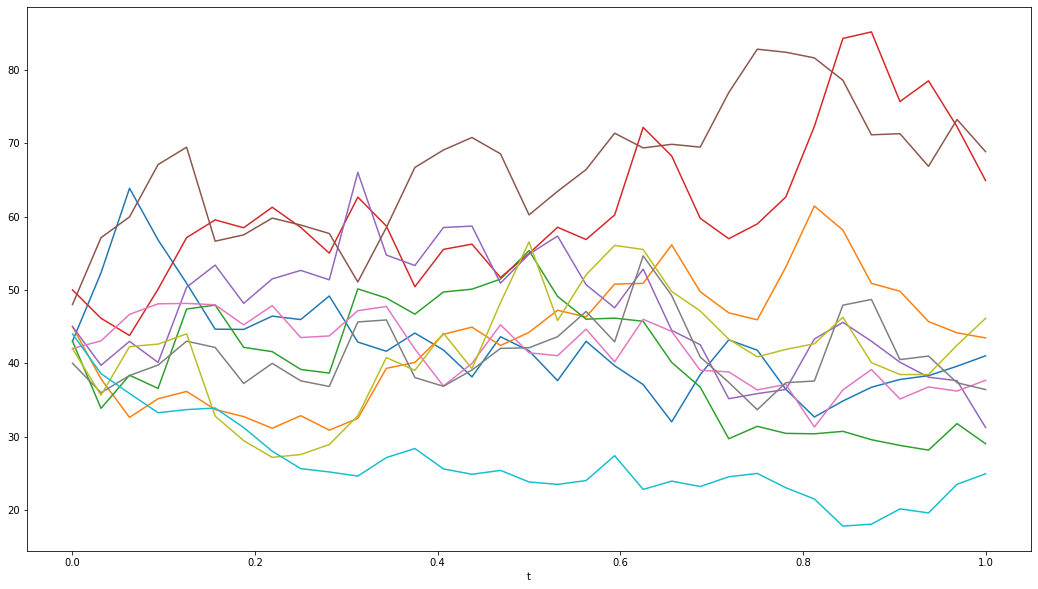

In [10]:
M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
M = np.cumsum(M, axis=1)
M = np.dot(np.transpose(sigma), M)
 
M = np.diff(M, axis=1)
M = M + tilde_mu * delta_t
 
M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
M = np.cumsum(M, axis=1)
 
M = np.exp(M)
for i in range(N_assets):
    M[i,:] = M[i,:] * X_0[i]
    
t = np.linspace(0, T, N+1) 
plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M))
plt.xlabel("t")
plt.show()

In [11]:
N_sample = 5000
outcomes = []
 
start_time = time.time()
 
for i in trange(N_sample):
    M = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    M = np.cumsum(M, axis=1)
    M = np.dot(np.transpose(sigma), M)
 
    M = np.diff(M, axis=1)
    M = M + tilde_mu * delta_t
 
    M = np.concatenate((np.zeros((N_assets,1)),M), axis=1)
    M = np.cumsum(M, axis=1)
 
    M = np.exp(M)
    for j in range(N_assets):
        M[j,:] = M[j,:] * X_0[j]
        
    outcomes = outcomes + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)]
 
elapsed_time = time.time() - start_time
 
mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)
 
print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
 
print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

  0%|          | 0/5000 [00:00<?, ?it/s]

elapsed time:  00:00:01
Mean (MC):  1.8553
Standard error (MC):  0.6087  ( 32.81 % )


In [12]:
layers = []
 
layer = Dense(20, activation="tanh", trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.1), 
              bias_initializer=initializers.RandomNormal(0.0, 0.1), 
              name=str(0))
 
layers = layers + [layer]
 
layer = Dense(N_assets, activation="linear", trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.1), 
              bias_initializer=initializers.RandomNormal(0.0, 0.1), 
              name=str(1))
 
layers = layers + [layer]

In [13]:
xtrain = ([0*np.ones((N_train,1))] + # t_0
          [delta_t*np.ones((N_train,N_assets))] + # time increment
          [0*np.ones((N_train,N_assets))] + # M_0
          [np.tile(X_0.reshape((N_assets)), (N_train, 1))] + # X_0
          [np.tile(weights.reshape((N_assets))/T, (N_train, 1))] + # wght
          [0*np.ones((N_train,N_assets))] + # initial value of the payoff
          [0*np.ones((N_train,N_assets))] + # initial value of the first part of the stoch exp
          [0*np.ones((N_train,N_assets))] + # initial value of the second part of the stoch exp
          [np.random.normal(0,np.sqrt(delta_t),(N_train,N_assets)) for i in range(N)]) # Brownian increments
 
ytrain = np.zeros((N_train, 1))

In [14]:
t_0 = Input(shape=(1, ))
d_t = Input(shape=(N_assets, ))
 
M_0 = Input(shape=(N_assets, ))
X_start = Input(shape=(N_assets, ))
 
wght = Input(shape=(N_assets, ))
 
c_0 = Input(shape=(N_assets, ))
c_1 = Input(shape=(N_assets, ))
c_2 = Input(shape=(N_assets, ))
 
inputs = [t_0]+[d_t]+[M_0]+[X_start]+[wght]+[c_0]+[c_1]+[c_2]
 
t_current = t_0
M_current = M_0
X_current = X_start
 
for j in range(N):
    
    strategy = t_current
    strategy = layers[0](strategy)
    strategy = layers[1](strategy)
    
    incr_M = Input(shape=(N_assets, ))
    inputs = inputs + [incr_M]
    
    M_current = Add()([M_current, incr_M])
    helper_0 = tf.transpose(K.dot(K.constant(np.transpose(sigma)), tf.transpose(M_current)))
    helper_1 = Lambda(lambda x: tilde_mu.reshape((N_assets)) * x)(t_current)
    helper_2 = Add()([helper_1, helper_0])
    helper_3 = Lambda(lambda x: K.exp(x))(helper_2)
    helper_4 = Multiply()([helper_3, d_t])
    helper_5 = Multiply()([X_start, helper_4])
    helper_6 = Multiply()([wght, helper_5])
    c_0 = Add()([c_0, helper_6])
    
    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    helper_e2 = Multiply()([strategy, strategy])
    helper_e3 = Multiply()([helper_e2, d_t])
    c_2 = Add()([c_2, helper_e3])
    
    t_current = Lambda(lambda x: x + delta_t)(t_current)
    
helper_e4 = Lambda(lambda x: -0.5 * K.sum(x, axis=1))(c_1)
helper_e5 = Lambda(lambda x: 0.25 * K.sum(x, axis=1))(c_2)
 
helper_e6 = Add()([helper_e4, helper_e5])
helper_e7 = Lambda(lambda x: K.exp(x))(helper_e6)
 
c_0 = Lambda(lambda x: K.sum(x, axis=1))(c_0)
c_0 = Lambda(lambda x: K.relu(x - strike))(c_0)
 
c_0 = Multiply()([c_0, helper_e7])
 
outputs = [c_0]

In [15]:
def custom_loss(y_true,y_pred):
    z = K.mean(K.square(y_pred))
    return z
 
adam = optimizers.Adam(learning_rate=learnrate)
 
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=adam,loss=custom_loss)

# model.summary()

In [ ]:
# K.set_value(model.optimizer.learning_rate, 0.0001)

In [17]:
model.fit(x=xtrain, y=ytrain, verbose=1, epochs=5, batch_size=1000, shuffle = True)

Epoch 1/5
200/200 [==============================] - 8s 30ms/step - loss: 0.0107
Epoch 2/5
200/200 [==============================] - 6s 31ms/step - loss: 0.0101
Epoch 3/5
200/200 [==============================] - 6s 31ms/step - loss: 0.0098
Epoch 4/5
200/200 [==============================] - 6s 31ms/step - loss: 0.0095
Epoch 5/5
200/200 [==============================] - 6s 31ms/step - loss: 0.0093


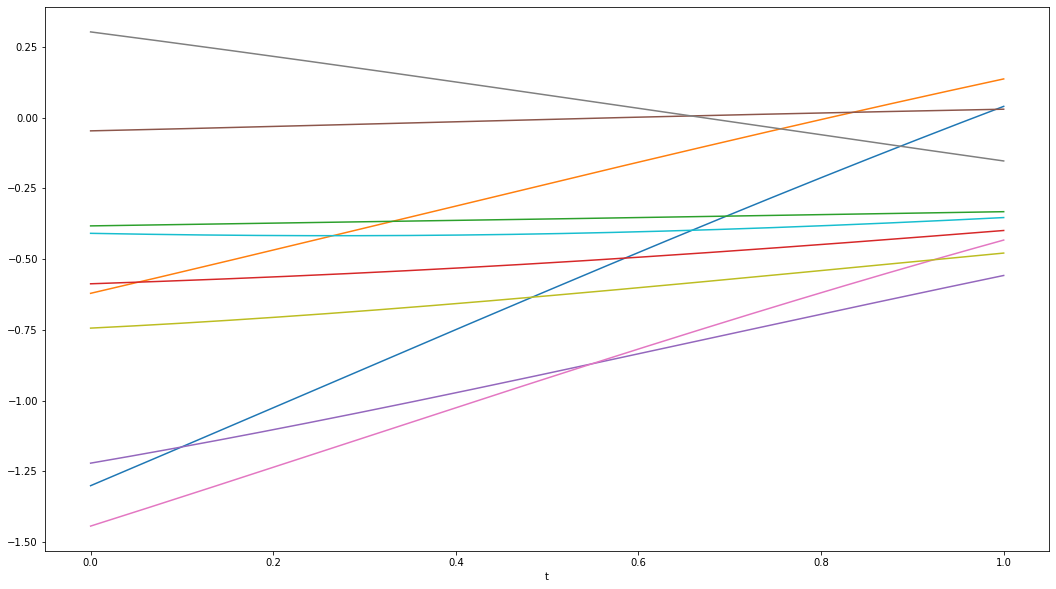

In [18]:
N = 252
delta_t = T/N
 
model_test = keras.Sequential()
model_test.add(Dense(20, activation="tanh", name="layer1", input_shape=(1, )))
model_test.add(Dense(N_assets, activation="linear", name="layer2"))
 
model_test.build()
 
model_test.layers[0].set_weights(model.layers[27].get_weights())
model_test.layers[1].set_weights(model.layers[38].get_weights())
 
t = np.linspace(0, T, N+1)
learnedstrat = model_test.predict(t)
 
plt.figure(figsize=(18, 10))
plt.plot(t, learnedstrat)
plt.xlabel("t")
plt.show()

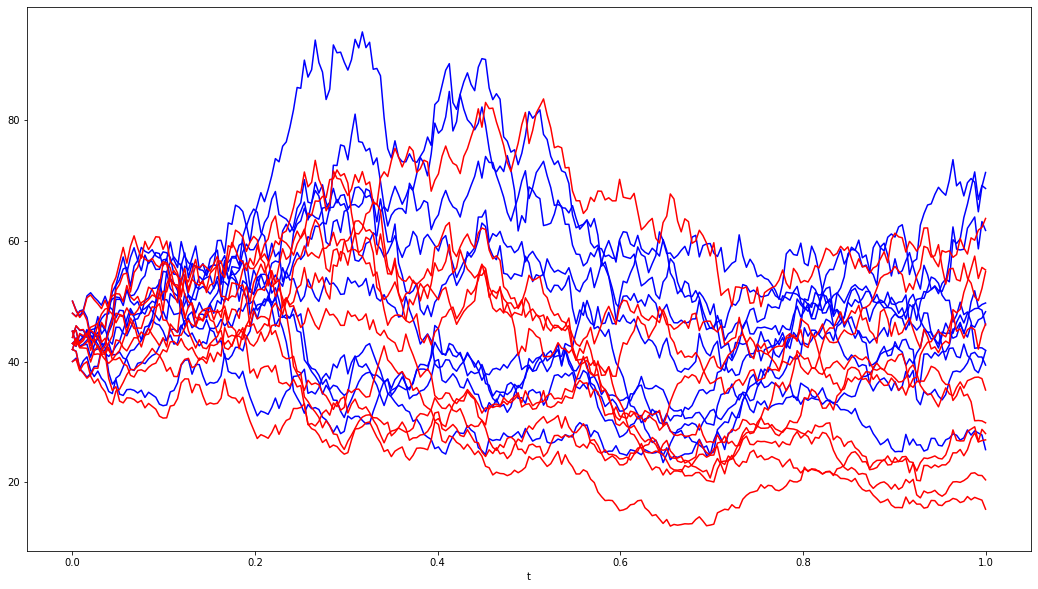

In [19]:
M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)

M_MC = np.cumsum(M_random, axis=1)
M_MC = np.dot(np.transpose(sigma), M_MC)

M_MC = np.diff(M_MC, axis=1)
M_MC = M_MC + tilde_mu * delta_t

M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
M_MC = np.cumsum(M_MC, axis=1)

M_MC = np.exp(M_MC)
for j in range(N_assets):
    M_MC[j,:] = M_MC[j,:] * X_0[j]
        
###

M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
M_0 = np.cumsum(M_0, axis=1)
M = np.dot(np.transpose(sigma), M_0)

M = np.diff(M, axis=1)
M = M + tilde_mu * delta_t

M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
M = np.cumsum(M, axis=1)

M = np.exp(M)
for j in range(N_assets):
    M[j,:] = M[j,:] * X_0[j]

plt.figure(figsize=(18, 10)) 
plt.plot(t, np.transpose(M), color = "blue", label="with drift adjustment")
plt.plot(t, np.transpose(M_MC), color = "red", label="without drift adjustment")
plt.xlabel("t")
plt.show()

In [28]:
N_reps = 100
N_sample = 5000
 
start_time = time.time()
 
means_MC = []
means_IS = []
 
stderr_MC = []
stderr_IS = []
 
varratio = []
 
for k in trange(N_reps):
    outcomes_MC = []
    outcomes_IS = []
    
    for i in range(N_sample):
        
        M_random = np.concatenate((np.zeros((N_assets,1)), np.random.normal(0, np.sqrt(delta_t), (N_assets,N))), axis=1)
    
        ##########
    
        M_MC = np.cumsum(M_random, axis=1)
        M_MC = np.dot(np.transpose(sigma), M_MC)
 
        M_MC = np.diff(M_MC, axis=1)
        M_MC = M_MC + tilde_mu * delta_t
 
        M_MC = np.concatenate((np.zeros((N_assets,1)),M_MC), axis=1)
        M_MC = np.cumsum(M_MC, axis=1)
 
        M_MC = np.exp(M_MC)
        for j in range(N_assets):
            M_MC[j,:] = M_MC[j,:] * X_0[j]
        
        ot_MC = np.clip(np.sum(np.multiply(weights, np.sum(M_MC * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * ot_MC]
 
        ##########
    
        M_0 = M_random + np.concatenate((np.zeros((N_assets,1)), np.transpose(learnedstrat[0:N,:]) * delta_t), axis=1)
    
        M_0 = np.cumsum(M_0, axis=1)
        M = np.dot(np.transpose(sigma), M_0)
 
        M = np.diff(M, axis=1)
        M = M + tilde_mu * delta_t
    
        M = np.concatenate((np.zeros((N_assets,1)), M), axis=1)
        M = np.cumsum(M, axis=1)
 
        M = np.exp(M)
        for j in range(N_assets):
            M[j,:] = M[j,:] * X_0[j]
        
        M_0 = np.diff(M_0, axis=1)
    
        adj1 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), M_0), axis=1), axis=0)
        adj2 = np.sum(np.sum(np.multiply(np.transpose(learnedstrat[0:N,:]), np.transpose(learnedstrat[0:N,:])) * delta_t, axis=1), axis=0)
    
        ot_IS = np.clip(np.sum(np.multiply(weights, np.sum(M * delta_t, axis=1).reshape((N_assets,1)) / T)) - strike, 0, None)
        
        outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * ot_IS * np.exp(-1 * adj1 + 0.5 * adj2)]
    
    means_MC = means_MC + [np.mean(outcomes_MC)]
    means_IS = means_IS + [np.mean(outcomes_IS)]
    
    stderr_MC = stderr_MC + [np.std(outcomes_MC) / np.sqrt(N_sample)]
    stderr_IS = stderr_IS + [np.std(outcomes_IS) / np.sqrt(N_sample)]
    
    varratio = varratio + [np.var(outcomes_MC) / np.var(outcomes_IS)]
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/100 [00:00<?, ?it/s]

total elapsed time:  00:07:04


In [29]:
print("Mean (MC): ", np.around(np.mean(means_MC), 4))
print("Mean (IS): ", np.around(np.mean(means_IS), 4))
print("Average standard error (MC): ", np.around(np.mean(stderr_MC), 4), " (", np.around(np.mean(stderr_MC) / np.mean(means_MC) * 100, 2), "% )")
print("Average standard error (IS): ", np.around(np.mean(stderr_IS), 4), " (", np.around(np.mean(stderr_IS) / np.mean(means_IS) * 100, 2), "% )")
print("Average variance ratio: ", np.around(np.mean(varratio)))

Mean (MC):  1.6585
Mean (IS):  1.7234
Average standard error (MC):  0.5212  ( 31.43 % )
Average standard error (IS):  0.1155  ( 6.7 % )
Average variance ratio:  27.0


mean MC estimate:   1.6585
mean IS estimate:  1.7234


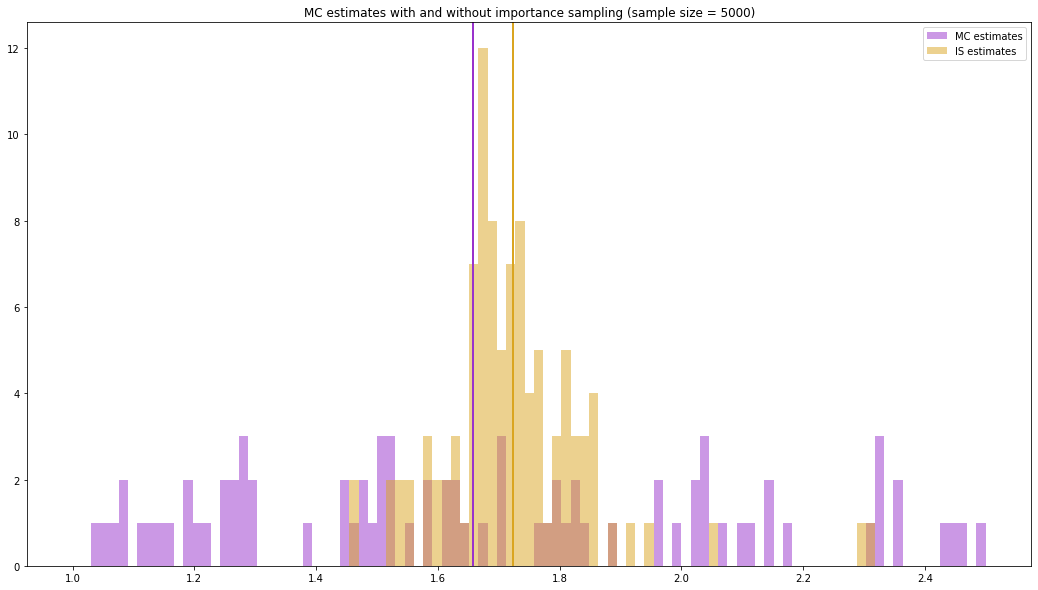

In [30]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(1.00, 2.50, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

mean MC estimate standard error:   0.5212
mean IS estimate standard error:  0.1155


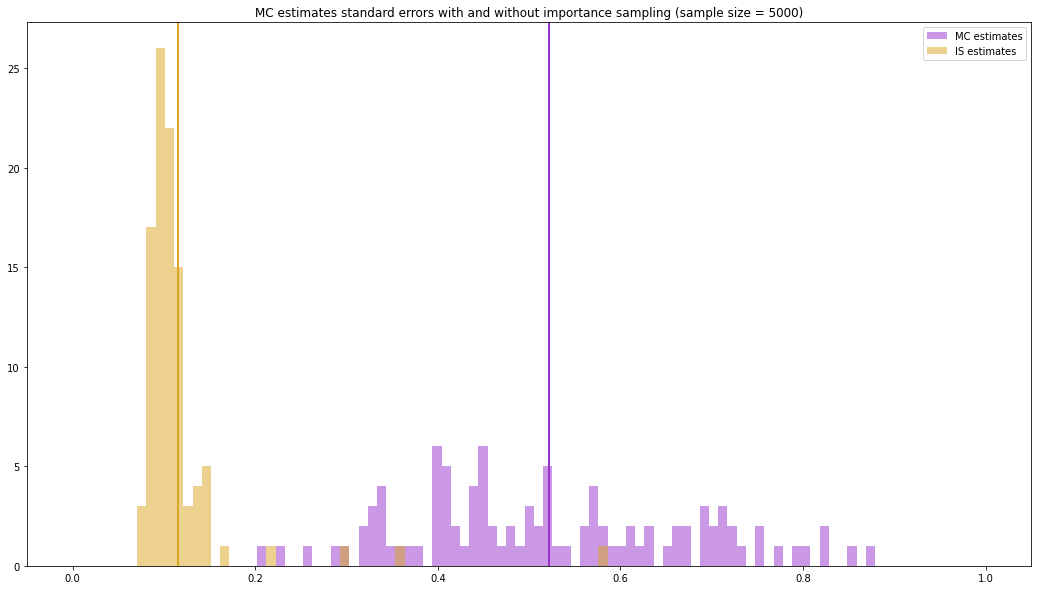

In [31]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 1.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

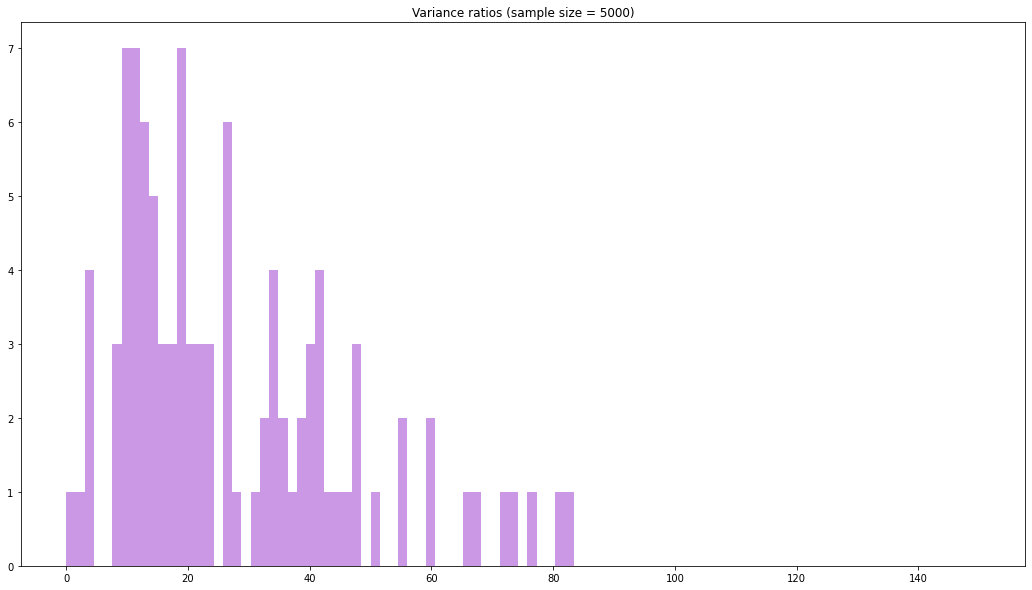

In [36]:
bins = np.linspace(0.00, 150.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.title("Variance ratios (sample size = 5000)")
plt.show()

In [38]:
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'varratio': varratio}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(15))

     mean MC   mean IS  stderr MC  stderr IS   varratio
31  2.487342  1.681155   0.664517   0.096332  47.585363
83  2.106071  1.790606   0.722046   0.104504  47.738008
96  2.319531  1.745536   0.699225   0.100962  47.964076
95  2.038016  1.722238   0.753911   0.105359  51.203090
60  3.383250  1.861581   0.824620   0.111295  54.897903
43  2.093208  1.782185   0.710131   0.094914  55.977579
67  2.462967  1.638654   0.675187   0.087603  59.403882
70  2.035415  1.761463   0.772334   0.099910  59.758037
4   2.437214  1.653921   0.731708   0.089722  66.508735
84  2.532134  1.604483   0.715484   0.086878  67.822900
42  2.834414  1.720751   0.872929   0.103313  71.391459
68  2.324143  1.589245   0.708791   0.082694  73.465674
50  1.893117  1.519548   0.676144   0.077005  77.097188
74  2.810607  1.685128   0.849404   0.093907  81.815433
66  2.352280  1.634247   0.827373   0.091152  82.388524
